# Level 2 Intermediate Notebook

Regression, time series, and clustering using your datasets.

Generated on 2025-09-29 19:07:11 UTC.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Your Windows paths
iris_path  = Path(r"C:\Users\mfgdiags1\Downloads\1) iris.csv")
stock_path = Path(r"C:\Users\mfgdiags1\Downloads\2) Stock Prices Data Set.csv")
senti_path = Path(r"C:\Users\mfgdiags1\Downloads\3) Sentiment dataset.csv")
house_path = Path(r"C:\Users\mfgdiags1\Downloads\4) house Prediction Data Set.csv")

def load_csv(path):
    return pd.read_csv(path, encoding="utf-8")

# Load data from your local machine
house = load_csv(house_path)
stock = load_csv(stock_path)
iris  = load_csv(iris_path)
# Sentiment is optional for this notebook, but loaded here if you need it later
try:
    senti = load_csv(senti_path)
except FileNotFoundError:
    senti = None
    print("Note: Could not find the sentiment file at the given path. Skipping it for now.")

def clean_dataframe(df):
    df = df.copy()
    for c in df.select_dtypes(include=["object"]).columns:
        df[c] = df[c].astype(str).str.strip()
    before = len(df)
    df = df.drop_duplicates()
    print("Removed duplicates:", before - len(df))
    num_cols = df.select_dtypes(include=[np.number]).columns
    obj_cols = df.select_dtypes(exclude=[np.number]).columns
    for c in num_cols:
        if df[c].isna().any():
            df[c] = df[c].fillna(df[c].median())
    for c in obj_cols:
        if df[c].isna().any():
            mode_val = df[c].mode(dropna=True)
            df[c] = df[c].fillna(mode_val.iloc[0] if not mode_val.empty else "unknown")
    return df

house = clean_dataframe(house)
stock = clean_dataframe(stock)
iris  = clean_dataframe(iris)
if senti is not None:
    senti = clean_dataframe(senti)


# Task 1 Regression Analysis

In [3]:

target_candidates = [c for c in house.columns if c.lower() in ["price","saleprice","median house price","target"]]
if len(target_candidates) == 0:
    num_cols = house.select_dtypes(include=[np.number]).columns
    y_col = num_cols[-1] if len(num_cols) >= 2 else None
else:
    y_col = target_candidates[0]

if y_col:
    X = house.drop(columns=[y_col]).select_dtypes(include=[np.number])
    X = X.loc[:, X.std() > 0]
    y = house[y_col].astype(float)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    lr = LinearRegression()
    lr.fit(X_train_s, y_train)
    y_pred = lr.predict(X_test_s)
    print("Target:", y_col)
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("R2:", r2_score(y_test, y_pred))
else:
    print("Could not determine a regression target in house dataset")


Could not determine a regression target in house dataset


# Task 2 Time Series Analysis

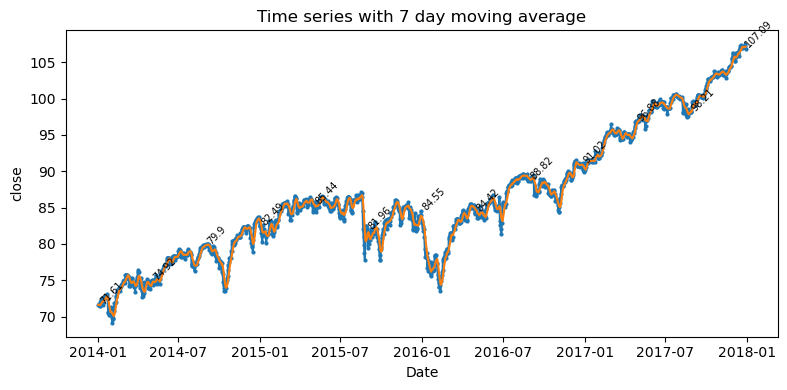

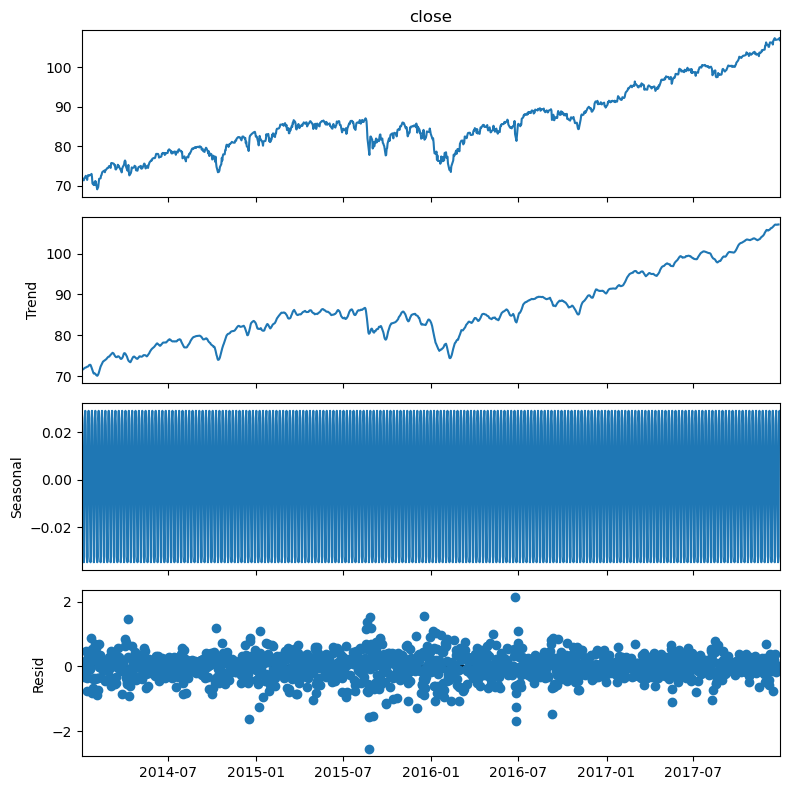

In [5]:
# Find the date and price columns
date_col = None
value_col = None
for c in stock.columns:
    if "date" in c.lower():
        date_col = c
        break
for c in stock.columns:
    if c.lower() in ["close", "adj close", "price"]:
        value_col = c
        break

if date_col and value_col:
    ts = stock[[date_col, value_col]].copy()

    # make sure date is parsed and price is numeric
    ts[date_col] = pd.to_datetime(ts[date_col], errors="coerce")
    ts[value_col] = pd.to_numeric(ts[value_col], errors="coerce")

    # drop bad rows and sort
    ts = ts.dropna(subset=[date_col, value_col]).sort_values(date_col)

    # set datetime index
    ts = ts.set_index(date_col)

    # if there are multiple rows per day, average them
    ts = ts.groupby(ts.index.normalize()).mean()

    # ensure strictly one row per day, then fill missing days
    ts = ts.asfreq("D")  # now safe because the index is daily dates
    ts[value_col] = ts[value_col].interpolate(method="time")

    # moving average
    ts["MA_7"] = ts[value_col].rolling(7, min_periods=1).mean()

    # plot with light value labels to avoid clutter
    plt.figure(figsize=(8,4))
    plt.plot(ts.index, ts[value_col], marker="o", markersize=2)
    plt.plot(ts.index, ts["MA_7"])
    plt.title("Time series with 7 day moving average")
    plt.xlabel("Date")
    plt.ylabel(value_col)
    step = max(1, len(ts)//12)
    for i in range(0, len(ts), step):
        y = float(ts[value_col].iloc[i])
        plt.text(ts.index[i], y, str(round(y,2)), fontsize=7, rotation=45)
    plt.tight_layout()
    plt.show()

    # seasonal decomposition
    try:
        decomp = sm.tsa.seasonal_decompose(ts[value_col], model="additive", period=7)
        fig = decomp.plot()
        fig.set_size_inches(8,8)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Decomposition failed:", e)
else:
    print("Could not find date and price-like columns")



# Task 3 Clustering Analysis K Means

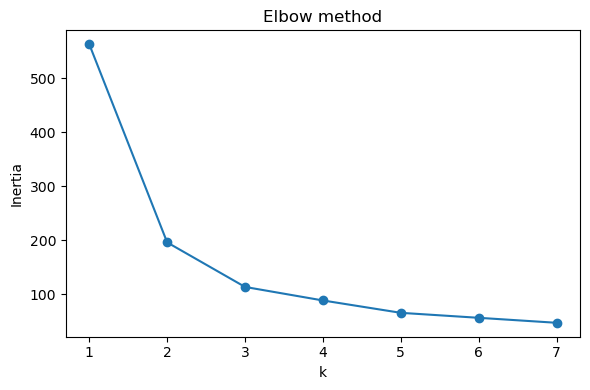

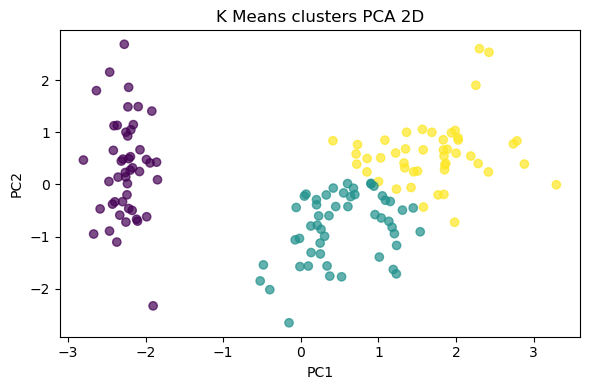

In [7]:
import warnings
from threadpoolctl import threadpool_limits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Silence just this specific MKL warning
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak", category=UserWarning)

X = iris.select_dtypes(include=[np.number])
if X.shape[1] >= 2:
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(Xs)

    # Elbow method
    inertias = []
    ks = range(1, 8)
    with threadpool_limits(limits=1):   # avoid MKL warning
        for k in ks:
            km = KMeans(n_clusters=k, n_init=10, random_state=42)
            km.fit(X2)
            inertias.append(km.inertia_)

    plt.figure(figsize=(6,4))
    plt.plot(list(ks), inertias, marker="o")
    plt.title("Elbow method")
    plt.xlabel("k")
    plt.ylabel("Inertia")
    plt.tight_layout()
    plt.show()

    # Final clustering
    with threadpool_limits(limits=1):   # avoid MKL warning
        km = KMeans(n_clusters=3, n_init=10, random_state=42)
        labels = km.fit_predict(X2)

    plt.figure(figsize=(6,4))
    plt.scatter(X2[:,0], X2[:,1], c=labels, alpha=0.7)
    plt.title("K Means clusters PCA 2D")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for clustering")
